## Постановка задачи
Участникам хакатона предстоит разработать ML–модель, которая по
названиям, атрибутам и картинкам сможет ответить на вопрос являются ли
два товара одинаковыми. Модель должна найти среди предложенных
пар-кандидатов как можно больше одинаковых товаров с долей ошибок
меньше 25%. Это решение поможет клиентам Ozon улучшить
пользовательский опыт, а компании — оптимизировать ресурсы и
сэкономить на закупке серверного оборудования

### Import

In [54]:
import json
from functools import partial
from typing import List

from datetime import datetime, timedelta
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix, auc

from fuzzywuzzy import fuzz

import plotly.express as px

from sentence_transformers import SentenceTransformer, util



import torch
from torch.nn.functional import cosine_similarity
torch.__version__

'2.0.1+cu118'

In [8]:

print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")


Is CUDA available: True
CUDA device count: 1
Device 0: NVIDIA GeForce RTX 2080 SUPER


### Load data

In [9]:
dataset = pd.read_parquet("hackathon_files_for_participants_ozon/train_pairs.parquet")
etl = pd.read_parquet("hackathon_files_for_participants_ozon/train_data.parquet")

### Embedings NLP

In [10]:
model_NLP = SentenceTransformer('all-MiniLM-L6-v2')
try:
    embeddings1 = np.load('embeddings1.npy')
except:
    # Compute and cache embeddings
    embeddings1 = model_NLP.encode(etl['name'],batch_size=16,show_progress_bar=True).tolist()
    np.save('embeddings1.npy', embeddings1)



Batches:   0%|          | 0/28567 [00:00<?, ?it/s]

In [11]:
etl["Name_emb_MiniLM"] = embeddings1

In [12]:

etl["all_cats"] = etl["categories"].apply(lambda x :json.loads(x))
etl["main_cat"] = etl["all_cats"].apply(lambda x : x["2"])
etl = etl[etl["main_cat"]=="Электроника"]
etl["sub_cat"] = etl["all_cats"].apply(lambda x : x["3"])
etl["type_cat"] = etl["all_cats"].apply(lambda x : x["4"])


Get raw data for each variantid.

In [13]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

Features functions.

In [14]:
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features

def compare_groups(text1, text2):
    return fuzz.ratio(text1, text2)*0.01

def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features

def compare_characteristics(x,y,fuz=False,threshhold=95):
    """fuzz     : bool   if set True provide threshhold from 0-100 : int"""
    if x == None or y == None:
        return 0
    
    x= json.loads(x)
    y= json.loads(y)
    length = max([len(x),len(y)])
    count_of_look_alikes=0
    for i in x.keys():
        if i in y.keys():
            if x[i] == y[i]:
                count_of_look_alikes+=1
    
    return (count_of_look_alikes/length)*0.01

def NLP_cosine(txt1,txt2):
    if txt1 is not None:

        return util.cos_sim(txt1, txt2).diagonal()
    
def NLP_euclidean(txt1,txt2):
    if txt1 is not None:

        return euclidean(txt1, txt2)
    
def pic_best_dist(pic_list_1,pic_list_2):
    best_euclid =[]
    best_cosine =[]

    if pic_list_1 is not None and pic_list_2 is not None:

        for i in pic_list_1:
            
            pic_best_euclid=100.0
            pic_best_cosine=0.0

            for k in pic_list_2:
                
                e = euclidean(i, k)
                

                if e<pic_best_euclid:
                    pic_best_euclid=e
                    pic_best_cosine=util.cos_sim(i, k).diagonal().numpy()
            
            best_euclid.append(pic_best_euclid)
            best_cosine.append(float(pic_best_cosine))
            
    else:
        return([-1,-1])
    alikeness_score = len([ i for i in best_euclid if i < 0.1  ])/len(best_euclid)
    alikeness_cosine_score = np.mean(best_cosine)

    return ([alikeness_score,alikeness_cosine_score])


In [15]:
def pipeline(features):
    features["characteristic_aliknes_score"]=features[["characteristic_attributes_mapping1","characteristic_attributes_mapping2"]].apply(
    lambda x: pd.Series(compare_characteristics(*x)),axis=1
)
    get_pic_features_func = partial(
        get_pic_features,
        percentiles=[0, 25, 50])

    features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
        features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(get_pic_features_func(*x)), axis=1
        )
    )

    features[["main_pic_dist_0_perc", "main_pic_dist_25_perc", "main_pic_dist_50_perc"]] = (
        features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(get_pic_features_func(*x)), axis=1
        )
    )

    features[["pic_alikeness_score","pic_alikeness_cosine_score"]] = (
        features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(pic_best_dist(*x)), axis=1
        )
    )

    features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
        features[["name_bert_641", "name_bert_642"]].apply(
            lambda x: pd.Series(text_dense_distances(*x)), axis=1
        )
    )

    features[[ "cosine_name_Name_emb_MiniLM"]] = (
        features[["Name_emb_MiniLM1", "Name_emb_MiniLM2"]].apply(
            lambda x: pd.Series(NLP_cosine(*x)), axis=1
        )
    )

    features[[ "euclidean_name_Name_emb_MiniLM"]] = (
        features[["Name_emb_MiniLM1", "Name_emb_MiniLM2"]].apply(
            lambda x: pd.Series(NLP_euclidean(*x)), axis=1
        )
    )

    features[["fuzz_type"]] = (
        features[["type_cat1", "type_cat2"]].apply(
            lambda x: pd.Series(compare_groups(*x)), axis=1
        )
    )
    features[["fuzz_name"]] = (
        features[["name1", "name2"]].apply(
            lambda x: pd.Series(compare_groups(*x)), axis=1
        )
    )



In [ ]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [16]:
pipeline(features)

### Feedforward Neural Network (FNN)

In [31]:
NN_feats = [
    "characteristic_aliknes_score","pic_alikeness_score","pic_alikeness_cosine_score",
    "cosine_name_bert_dist","cosine_name_Name_emb_MiniLM","fuzz_type","fuzz_name"
    ]
bad_score_group=["Защитные пленки и стекла","Чехол","Компьютер","Электронные модули",
                 "Кабели и переходники","Оперативная память","Карты памяти и флешки","Запчасти для ноутбуков"]
len(NN_feats)

7

In [32]:

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score


In [33]:
class FNN_G(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(FNN_G, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        
        return out

input_size = 7
output_size = 1
hidden_size = 64

model_NN_good = FNN_G(input_size=input_size, output_size=output_size,
            hidden_size=hidden_size)

In [34]:
class FNN_B(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(FNN_B, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        
        return out

input_size = 7
output_size = 1
hidden_size = 64

model_NN_BAD = FNN_B(input_size=input_size, output_size=output_size,
            hidden_size=hidden_size)

In [145]:
inputs = torch.tensor(features[NN_feats].values, dtype=torch.float32)
outputs = torch.tensor(features[['target']].values, dtype=torch.float32)
dataset = TensorDataset(inputs, outputs)
dataloader = DataLoader(dataset, batch_size=7)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_NN_good.parameters(),lr=0.0001)


In [146]:

num_epochs = 30
for epoch in range(num_epochs):
    for batch_inputs, batch_outputs in dataloader:
        # Forward pass
        outputs = model_NN_good(batch_inputs)
        loss = criterion(outputs, batch_outputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch: 1/30, Loss: 0.3299
Epoch: 2/30, Loss: 0.3087
Epoch: 3/30, Loss: 0.2922
Epoch: 4/30, Loss: 0.2784
Epoch: 5/30, Loss: 0.2595
Epoch: 6/30, Loss: 0.2527
Epoch: 7/30, Loss: 0.2447
Epoch: 8/30, Loss: 0.2373
Epoch: 9/30, Loss: 0.2303
Epoch: 10/30, Loss: 0.2266
Epoch: 11/30, Loss: 0.2254
Epoch: 12/30, Loss: 0.2310
Epoch: 13/30, Loss: 0.2318
Epoch: 14/30, Loss: 0.2382
Epoch: 15/30, Loss: 0.2331
Epoch: 16/30, Loss: 0.2361
Epoch: 17/30, Loss: 0.2347
Epoch: 18/30, Loss: 0.2369
Epoch: 19/30, Loss: 0.2364
Epoch: 20/30, Loss: 0.2355
Epoch: 21/30, Loss: 0.2409
Epoch: 22/30, Loss: 0.2401
Epoch: 23/30, Loss: 0.2317
Epoch: 24/30, Loss: 0.2375
Epoch: 25/30, Loss: 0.2313
Epoch: 26/30, Loss: 0.2299
Epoch: 27/30, Loss: 0.2225
Epoch: 28/30, Loss: 0.2240
Epoch: 29/30, Loss: 0.2178
Epoch: 30/30, Loss: 0.2172


In [147]:
inputs = torch.tensor(features[features["cat3_grouped"].isin(bad_score_group)][NN_feats].values, dtype=torch.float32)
outputs = torch.tensor(features[features["cat3_grouped"].isin(bad_score_group)][['target']].values, dtype=torch.float32)
dataset = TensorDataset(inputs, outputs)
dataloader = DataLoader(dataset, batch_size=7)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_NN_BAD.parameters(),lr=0.0001)


In [148]:

num_epochs = 30
for epoch in range(num_epochs):
    for batch_inputs, batch_outputs in dataloader:
        # Forward pass
        outputs = model_NN_BAD(batch_inputs)
        loss = criterion(outputs, batch_outputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch: 1/30, Loss: 0.2092
Epoch: 2/30, Loss: 0.2012
Epoch: 3/30, Loss: 0.1953
Epoch: 4/30, Loss: 0.1933
Epoch: 5/30, Loss: 0.1902
Epoch: 6/30, Loss: 0.1871
Epoch: 7/30, Loss: 0.1847
Epoch: 8/30, Loss: 0.1831
Epoch: 9/30, Loss: 0.1824
Epoch: 10/30, Loss: 0.1826
Epoch: 11/30, Loss: 0.1818
Epoch: 12/30, Loss: 0.1811
Epoch: 13/30, Loss: 0.1806
Epoch: 14/30, Loss: 0.1806
Epoch: 15/30, Loss: 0.1809
Epoch: 16/30, Loss: 0.1792
Epoch: 17/30, Loss: 0.1784
Epoch: 18/30, Loss: 0.1770
Epoch: 19/30, Loss: 0.1739
Epoch: 20/30, Loss: 0.1721
Epoch: 21/30, Loss: 0.1691
Epoch: 22/30, Loss: 0.1626
Epoch: 23/30, Loss: 0.1602
Epoch: 24/30, Loss: 0.1560
Epoch: 25/30, Loss: 0.1530
Epoch: 26/30, Loss: 0.1507
Epoch: 27/30, Loss: 0.1500
Epoch: 28/30, Loss: 0.1482
Epoch: 29/30, Loss: 0.1480
Epoch: 30/30, Loss: 0.1437


In [149]:
torch.save(model_NN_good,"models/FNN_good.pt")
torch.save(model_NN_BAD,"models/FNN_bad.pt")

In [35]:
model_NN_good = torch.load("models/FNN_good.pt")
model_NN_BAD = torch.load("models/FNN_bad.pt")

In [36]:
inputs = torch.tensor(features[NN_feats].values, dtype=torch.float32)

In [37]:
with torch.no_grad():
    predictionsg = model_NN_good(inputs)
    predictionsb= model_NN_BAD(inputs)

In [38]:
features["FNN_predictions"]=predictionsg.numpy()

In [39]:
features["FNN_predictions"][features["cat3_grouped"].isin(bad_score_group)] =  predictionsb.numpy()

C:\Users\UP\AppData\Local\Temp\ipykernel_14820\2428002241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["FNN_predictions"][features["cat3_grouped"].isin(bad_score_group)] =  predictionsb.numpy()


# Ensambles ML

In [42]:
feats = ["main_pic_dist_0_perc", "main_pic_dist_25_perc", "main_pic_dist_50_perc", 
    "pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist","cosine_name_Name_emb_MiniLM",
         "euclidean_name_Name_emb_MiniLM",'pic_alikeness_score', 'pic_alikeness_cosine_score',"FNN_predictions", 'fuzz_type', 'fuzz_name'
         ]

In [47]:
RANDOM_STATE = 42

In [48]:
# Разбиваю сет так же как в бейзлайне, только по cat3_grouped делаю ohe

features_encoded = pd.get_dummies(features, columns=['cat3_grouped'])

X_train, X_test = train_test_split(
    features_encoded[feats + ["target", "variantid1", "variantid2"]], 
    test_size=0.3, random_state=42, stratify=features_encoded[["target"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2"]], 
    test_size=0.3, random_state=42, stratify=X_train[["target"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


In [49]:
# Список моделей
models_list = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'),
}

In [50]:

def time_format(sec):
    return str(timedelta(seconds=sec))

In [53]:
# Обучение (запускать блок если нет моделей)
for model_name, model in models_list.items():
    start_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    print()

***********************************Start fit Logistic Regression************************************
***********************End fit Logistic Regression, run time: 0:00:01.859946************************

*********************************Start fit Random Forest Classifier*********************************
*********************End fit Random Forest Classifier, run time: 0:00:09.044751*********************

*****************************************Start fit XGBoost******************************************
*****************************End fit XGBoost, run time: 0:00:05.704208******************************

*****************************************Start fit LightGBM*****************************************
*****************************End fit LightGBM, run time: 0:00:00.556906*****************************

*****************************************Start fit CatBoost*****************************************
*****************************End fit CatBoost, run time: 0:00:14.704760****************

In [56]:
def get_classification_report(models_list, X_train, y_train, 
                                        X_valid, y_valid, 
                                        classes,
                                        title='',
                                        threshold=0.5):
    
    for model_name, model in models_list.items():
        print()
        y_train_pred = model.predict_proba(X_train)[:,1]
        y_valid_pred = model.predict_proba(X_valid)[:,1]
        
        y_train_pred = y_train_pred > threshold
        y_valid_pred = y_valid_pred > threshold
        
        print(f'{model_name}. {title}'.center(53, '*'))
        print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
        print('VALID\n\n' + classification_report(y_valid, y_valid_pred))
        plt.figure(figsize=(7, 4))
        plot_confusion_matrix(y_valid, y_valid_pred, classes=classes, title=f'Confusion matrix.\n {model_name}. {title}')
        plt.show()
        print('_'*53)
        print('\n')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center', fontsize=16,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #filename = title.replace("\n","") + '.png'
    #plt.savefig(filename, format='png', dpi=300)
    
def plot_roc_pr(models_list, X_train, y_train, X_valid, y_valid, title='', threshold=0.5):

    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    
    f.set_figheight(10)
    f.set_figwidth(20)
    
    ax1 = plt.subplot(121)
    ax1.set_title(f'ROC. {title}')
    ax1.set_xlabel('TPR')
    ax1.set_ylabel('FPR')
    ax1.set_aspect('equal')
    ax1.plot([0, 1], [0, 1], 'k--')
    
    ax2 = plt.subplot(122)
    ax2.set_title(f'PR. {title}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_aspect('equal')
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax2.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02), fontsize=14)
        
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    for model_name, model in models_list.items():
        y_pred_proba = model.predict_proba(X_valid)[:,1]
        y_pred = y_pred_proba > threshold
        
        fpr, tpr, roc_thresholds = roc_curve(y_valid, y_pred_proba)
        precision, recall, pr_thresholds = precision_recall_curve(y_valid, y_pred_proba)
        
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC={auc(fpr, tpr):.2f})')       
        ax2.plot(recall, precision, label=f'{model_name} (f1={f1_score(y_valid, y_pred):.2f})')

    ax1.legend(loc="lower right")
    ax2.legend(loc="lower left")
    
    #filename = title.replace('\n', '') + '_ROC_PF.png'
    #plt.savefig(filename, format='png', dpi=300)
    
    plt.show()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(1, 1))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    
    #plt.savefig('show_proba_calibration_plots.png', format='png', dpi=300)
    plt.show()

C:\Users\UP\AppData\Local\Temp\ipykernel_14820\4043805371.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(121)


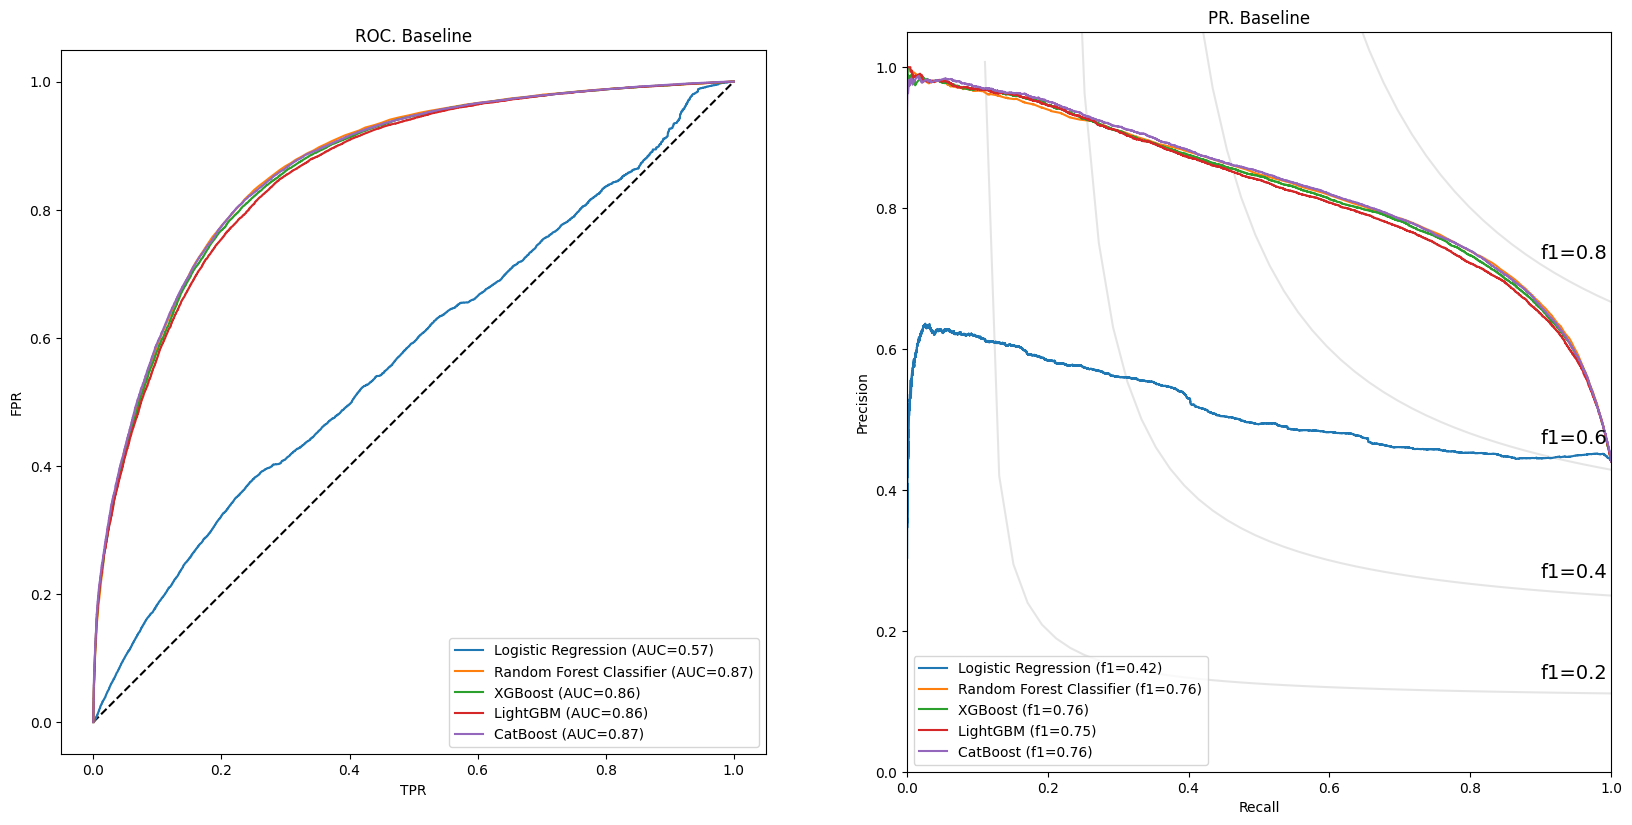

In [58]:
# Борд по бейз моделям
plot_roc_pr(models_list, X_train, y_train, X_val, y_val, title='Baseline')

In [64]:
def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]

    # get coordinates (x, y) for (recall, precision) of PR-curve
    y, x, _ = precision_recall_curve(y_true, y_pred)
    
    # reverse the lists so that x's are in ascending order (left to right)
    y = y[::-1]
    x = x[::-1]
    
    # get indices for x-coordinate (recall) where y-coordinate (precision) 
    # is higher than precision level (75% for our task)
    good_idx = np.where(y >= prec_level)[0]
    
    # if there are more than one such x's (at least one is always there, 
    # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
    # with acceptable precision
    if len(good_idx) > 1:
        gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
        return pr_auc_prec_level
        
    # if there is only one such x, then we have zeros in the top scores 
    # and the curve simply goes down sharply at x=0 and does not rise 
    # above the required precision: PRAUC=0
    else:
        return 0


In [65]:
# Создаем датафрейм с истинными значениями целевой переменной и значениями 'variantid1' и 'variantid2'
target_df = X_val[['variantid1', 'variantid2']].copy()
target_df['target'] = y_val

# Создаем пустой датафрейм для хранения прогнозов
predictions_df = pd.DataFrame()

# Для каждой модели в списке моделей
for model_name, model in models_list.items():
    # Получаем прогнозы на валидационной выборке
    y_pred = model.predict_proba(X_val)[:, 1]
    # Сохраняем прогнозы в датафрейме прогнозов
    predictions_df[model_name] = y_pred

# Добавляем значения 'variantid1' и 'variantid2' в датафрейм прогнозов
predictions_df[['variantid1', 'variantid2']] = X_val[['variantid1', 'variantid2']].values

# Для каждой модели в списке моделей
for model_name in models_list.keys():
    # Выбираем столбец с прогнозами для текущей модели
    model_predictions = predictions_df[['variantid1', 'variantid2', model_name]]
    # Переименовываем столбец с прогнозами в 'scores'
    model_predictions = model_predictions.rename(columns={model_name: 'scores'})
    # Вычисляем метрику качества для текущей модели
    score = pr_auc_macro(target_df, model_predictions, prec_level=0.75)
    # Выводим результаты
    print(f'{model_name}: {score:.4f}')


Logistic Regression: 0.0001
Random Forest Classifier: 0.6833
XGBoost: 0.6771
LightGBM: 0.6608
CatBoost: 0.6888


In [ ]:
import joblib

# Сохранение моделей
joblib.dump(models_list['CatBoost'], 'catboost_model.joblib')
joblib.dump(models_list['Random Forest Classifier'], 'random_forest_model.joblib')
joblib.dump(models_list['XGBoost'], 'xgboost_model.joblib')

In [ ]:
# Загрузка моделей
catboost_model = joblib.load('catboost_model.joblib')
random_forest_model = joblib.load('random_forest_model.joblib')
xgboost_model = joblib.load('xgboost_model.joblib')

In [66]:
# Получаем прогнозы модели XGBoost
y_pred_xgb = xgboost_model.predict_proba(X_val)[:, 1]

# Получаем прогнозы модели Random Forest Classifier
y_pred_rfc = random_forest_model.predict_proba(X_val)[:, 1]

# Получаем прогнозы модели CatBoost
y_pred_cat = catboost_model.predict_proba(X_val)[:, 1]

# Усредняем прогнозы двух моделей
y_pred_ensemble = (y_pred_xgb + y_pred_cat + y_pred_rfc) / 3


In [67]:
# Создаем датафрейм с истинными значениями целевой переменной и значениями 'variantid1' и 'variantid2'
target_df = X_val[['variantid1', 'variantid2']].copy()
target_df['target'] = y_val

# Создаем датафрейм с ансамблевыми прогнозами
predictions_df = pd.DataFrame({'scores': y_pred_ensemble})
predictions_df[['variantid1', 'variantid2']] = X_val[['variantid1', 'variantid2']].values

# Вычисляем метрику качества для ансамблевых прогнозов
score = pr_auc_macro(target_df, predictions_df)
print(f'Ensemble: {score:.4f}')

Ensemble: 0.7042


# Submission

In [68]:
test_pairs = pd.read_parquet("hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet")
test_etl = pd.read_parquet("hackathon_files_for_participants_ozon/test_data.parquet")

In [69]:
test_pairs.shape,test_etl.shape

((18084, 2), (35730, 8))

In [70]:
test_etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51201254,Колодка TDM Electric четырехместная без заземл...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],"[[0.34383398, -0.2962618, 0.07987049, -0.08257...","[[0.38310742, -0.7876679, 0.5018278, 0.2090071...","[-0.5060825, 0.5773388, 0.59435517, -0.4958292...","{""Страна-изготовитель"":[""Китай""],""Бренд"":[""TDM..."
1,77151532,Клавиатура черная с черной рамкой для 25-011879,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Запчаст...",[черный],None,"[[0.50964713, 0.7958329, -1.4113188, 0.1999381...","[-0.43467724, 0.6614495, 0.48050267, -0.588880...","{""Страна-изготовитель"":[""Китай""],""Комплектация..."


Generate the same features as for train

In [71]:
test_etl["all_cats"] = test_etl["categories"].apply(lambda x :json.loads(x))
test_etl["main_cat"] = test_etl["all_cats"].apply(lambda x : x["2"])
test_etl["sub_cat"] = test_etl["all_cats"].apply(lambda x : x["3"])
test_etl["type_cat"] = test_etl["all_cats"].apply(lambda x : x["4"])
test_etl = test_etl[test_etl["main_cat"]=="Электроника"]

In [72]:
try:
    embeddings1 = np.load('embeddingstest.npy')
except:
    # Compute and cache embeddings
    embeddings1 = model_NLP.encode(test_etl['name'],batch_size=16,show_progress_bar=True).tolist()
    np.save('embeddingstest.npy', embeddings1)


test_etl["Name_emb_MiniLM"] = embeddings1

Batches:   0%|          | 0/2234 [00:00<?, ?it/s]

In [73]:
test_features = (
    test_pairs
    .merge(
    test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
    test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [74]:
test_features.shape

(18084, 26)

In [75]:
def pipeline(features):
    features["characteristic_aliknes_score"]=features[["characteristic_attributes_mapping1","characteristic_attributes_mapping2"]].apply(
    lambda x: pd.Series(compare_characteristics(*x)),axis=1
)
    get_pic_features_func = partial(
        get_pic_features,
        percentiles=[0, 25, 50])

    features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
        features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(get_pic_features_func(*x)), axis=1
        )
    )

    features[["main_pic_dist_0_perc", "main_pic_dist_25_perc", "main_pic_dist_50_perc"]] = (
        features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(get_pic_features_func(*x)), axis=1
        )
    )

    features[["pic_alikeness_score","pic_alikeness_cosine_score"]] = (
        features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
            lambda x: pd.Series(pic_best_dist(*x)), axis=1
        )
    )

    features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
        features[["name_bert_641", "name_bert_642"]].apply(
            lambda x: pd.Series(text_dense_distances(*x)), axis=1
        )
    )

    features[[ "cosine_name_Name_emb_MiniLM"]] = (
        features[["Name_emb_MiniLM1", "Name_emb_MiniLM2"]].apply(
            lambda x: pd.Series(NLP_cosine(*x)), axis=1
        )
    )

    features[[ "euclidean_name_Name_emb_MiniLM"]] = (
        features[["Name_emb_MiniLM1", "Name_emb_MiniLM2"]].apply(
            lambda x: pd.Series(NLP_euclidean(*x)), axis=1
        )
    )

    features[["fuzz_type"]] = (
        features[["type_cat1", "type_cat2"]].apply(
            lambda x: pd.Series(compare_groups(*x)), axis=1
        )
    )
    features[["fuzz_name"]] = (
        features[["name1", "name2"]].apply(
            lambda x: pd.Series(compare_groups(*x)), axis=1
        )
    )
    

In [77]:
pipeline(test_features)

In [78]:
test_features["cat3"] = test_features["categories1"].apply(lambda x: json.loads(x)["3"])

In [79]:
test_features.shape

(18084, 42)

In [80]:
test_cat3_counts = test_features["cat3"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [81]:
test_features["cat3_grouped"] = test_features["cat3"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")
# btw you can rename to `rest` the same categories that were assigned to this group in train

In [82]:
model_NN_BAD = torch.load("models\FNN_bad.pt")
model_NN_good = torch.load("models\FNN_good.pt")

inputs = torch.tensor(test_features[NN_feats].values, dtype=torch.float32)
with torch.no_grad():
    predictionsg = model_NN_good(inputs)
    predictionsb= model_NN_BAD(inputs)

test_features["FNN_predictions"]=predictionsg.numpy()
test_features["FNN_predictions"][test_features["cat3_grouped"].isin(bad_score_group)] =  predictionsb.numpy()

C:\Users\UP\AppData\Local\Temp\ipykernel_14820\2984726210.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features["FNN_predictions"][test_features["cat3_grouped"].isin(bad_score_group)] =  predictionsb.numpy()


In [83]:
submission_example = test_features.copy()

In [84]:

feats = ["main_pic_dist_0_perc", "main_pic_dist_25_perc", "main_pic_dist_50_perc", 
    "pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist","cosine_name_Name_emb_MiniLM",
         "euclidean_name_Name_emb_MiniLM",'pic_alikeness_score', 'pic_alikeness_cosine_score',"FNN_predictions", 'fuzz_type', 'fuzz_name',
         "variantid1", "variantid2"]

In [85]:
features_encoded = pd.get_dummies(test_features, columns=['cat3_grouped'])

In [87]:
# Получаем прогнозы модели XGBoost
y_pred_xgb = xgboost_model.predict_proba(features_encoded[feats])[:, 1]

# Получаем прогнозы модели Random Forest Classifier
y_pred_rfc = random_forest_model.predict_proba(features_encoded[feats])[:, 1]

# Получаем прогнозы модели CatBoost
y_pred_cat = catboost_model.predict_proba(features_encoded[feats])[:, 1]

# Усредняем прогнозы двух моделей
y_pred_ensemble = (y_pred_xgb + y_pred_cat + y_pred_rfc) / 3

In [88]:
submission_example["target"] = model.predict_proba(test_features[feats])[:, 1]

In [89]:
submission_example = submission_example[["variantid1", "variantid2", "target"]]

In [90]:
submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_heroic2.csv", index=False)

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.